In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [26]:
import time
import matplotlib.pyplot as pl
import numpy as np
import itertools as it
from astropy.io import fits
import healpy as hp
from scipy import linalg

from src import core as cr
from src import this_project as P

In [3]:
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
LMAX = NSIDE
BEAMSIZE = 1.5

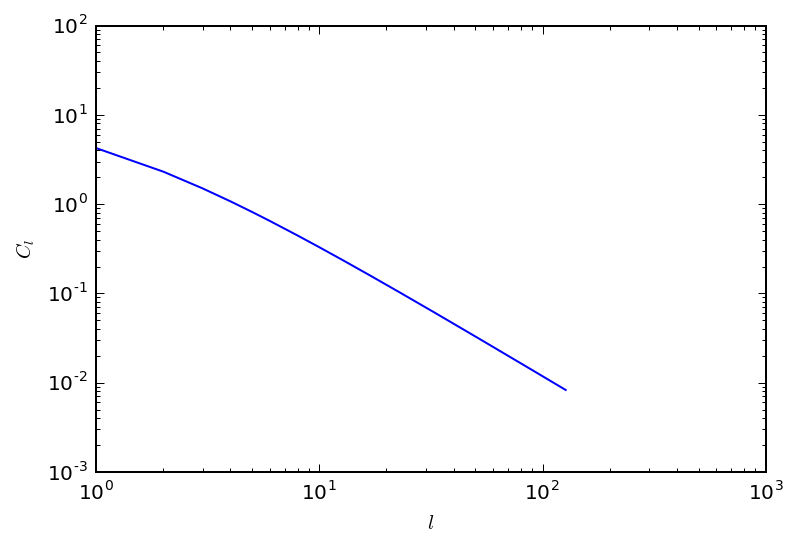

In [4]:
power = (lambda k: 12 / (k + 1) ** 1.5)
cl_in = power(np.arange(LMAX))
ls = np.arange(cl_in.size)
pl.loglog(cl_in)
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

Sigma is 38.219481 arcmin (0.011118 rad) 
-> fwhm is 90.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


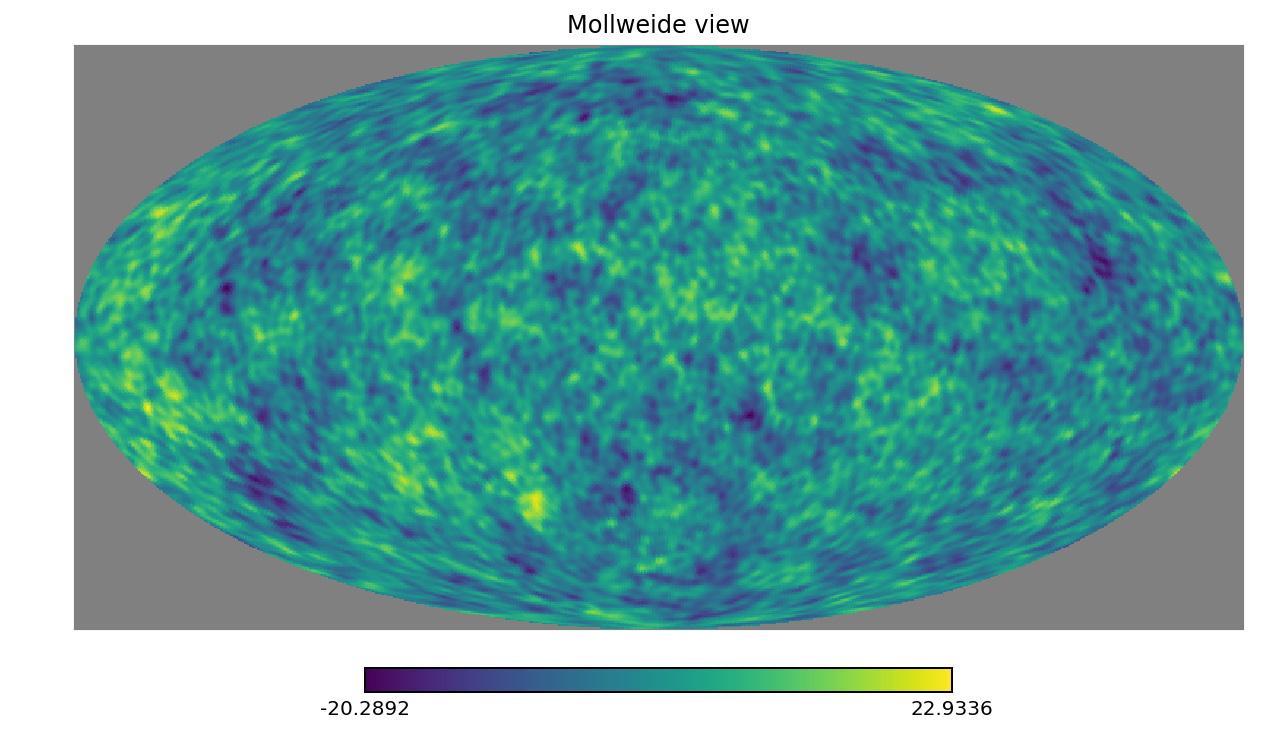

In [5]:
random_field = hp.synfast(cl_in, NSIDE, verbose=False)

# simulate beam
random_field = hp.smoothing(random_field, fwhm=np.deg2rad(BEAMSIZE), iter=1)
hp.mollview(random_field, cmap=P.CMAP)

In [10]:
full_mask = fits.getdata('/Users/dlenz/projects/planck/mask_galplane_2048.hpx.fits')
mask = hp.ud_grade(full_mask['GAL060'].astype(np.float32), NSIDE, order_in='nest', order_out='ring')
mask = hp.smoothing(mask, fwhm=np.deg2rad(1.), iter=1)

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


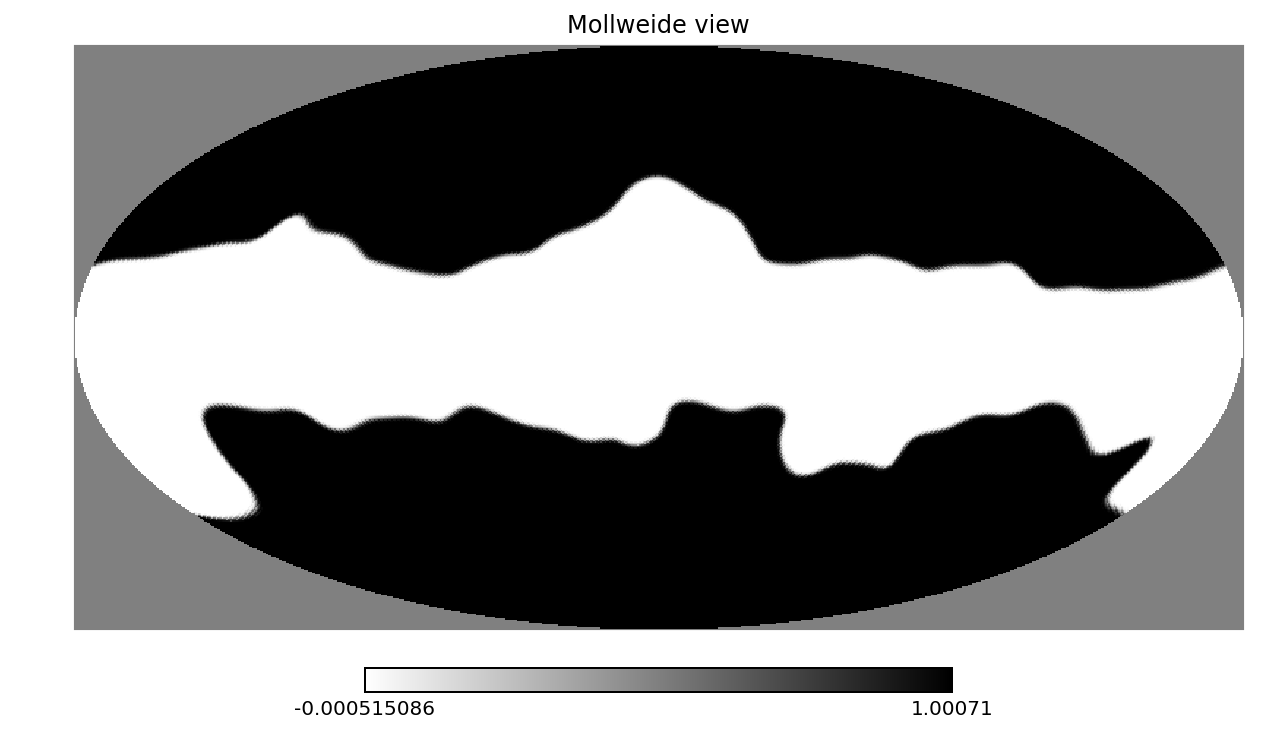

In [11]:
hp.mollview(mask, cmap=P.CMAP_GREY)

In [12]:
cl_mask = hp.anafast(mask, lmax=LMAX-1)

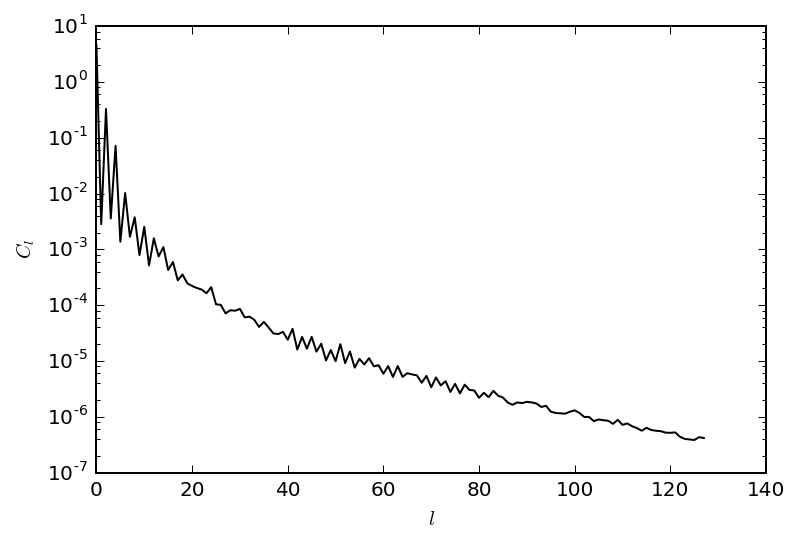

In [13]:
pl.plot(cl_mask, c='k')
pl.yscale('log')
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

In [14]:
pixfunc = hp.pixwin(NSIDE)[:LMAX]
beamfunc = hp.gauss_beam(np.deg2rad(BEAMSIZE), LMAX-1)
windowfunc = pixfunc * beamfunc

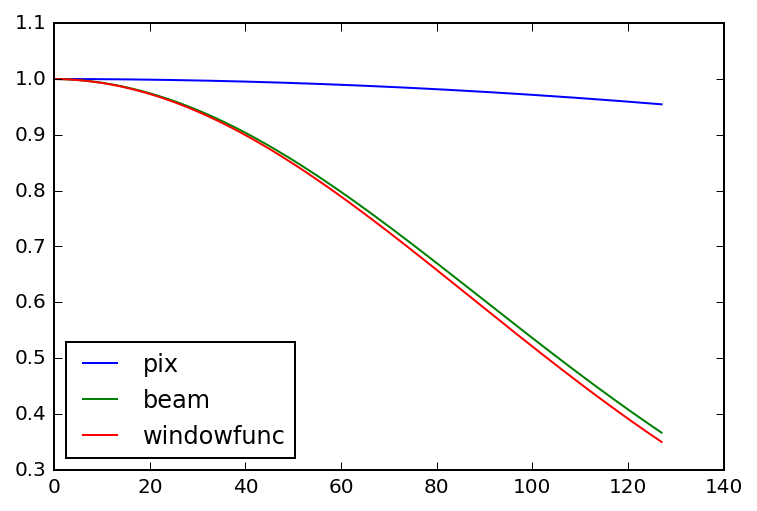

In [15]:
pl.plot(pixfunc, label='pix')
pl.plot(beamfunc, label='beam')
pl.plot(windowfunc, label='windowfunc')
pl.legend(loc='lower left')

In [90]:
cl_conv = hp.sphtfunc.anafast(random_field*mask, lmax=LMAX-1)

In [91]:
M = cr.make_M_l1l2(ls, W=cl_mask)

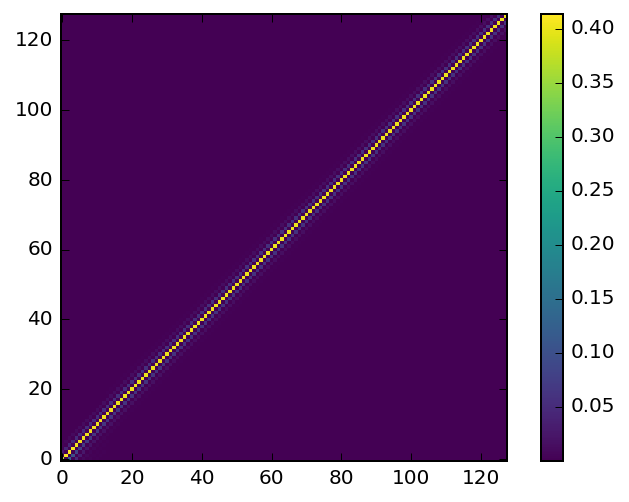

In [92]:
pl.imshow(M, interpolation='None', origin='lower', cmap=P.CMAP)
pl.colorbar()

In [93]:
M_inv = linalg.inv(M)

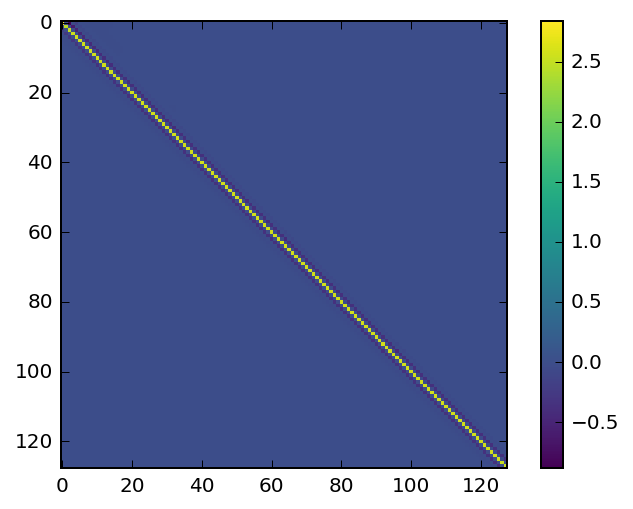

In [94]:
pl.imshow(M_inv, interpolation='None', cmap=P.CMAP)
pl.colorbar()

In [97]:
P_bl, bin_centres = cr.make_P_bl(ls, 25)
Q_lb, _ = cr.make_Q_lb(ls, 25)

In [98]:
cl_bin = np.dot(P_bl, cl_conv)

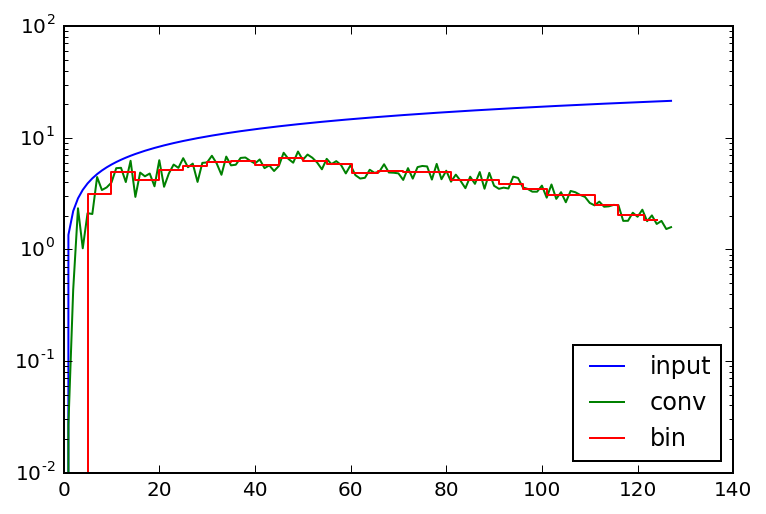

In [99]:
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_in, label='input')
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_conv, label='conv')
pl.plot(bin_centres, cl_bin, label='bin', drawstyle='steps-mid')
pl.legend(loc='best')
pl.yscale('log')

In [100]:
K_b1b2 = np.dot(P_bl, np.dot(M, ((windowfunc**2)[:, None]* Q_lb)))

In [101]:
K_inv = linalg.inv(K_b1b2[1:, 1:])

In [102]:
cl_deconv = np.dot(np.dot(K_inv, P_bl[1:, 1:]), cl_conv[1:])

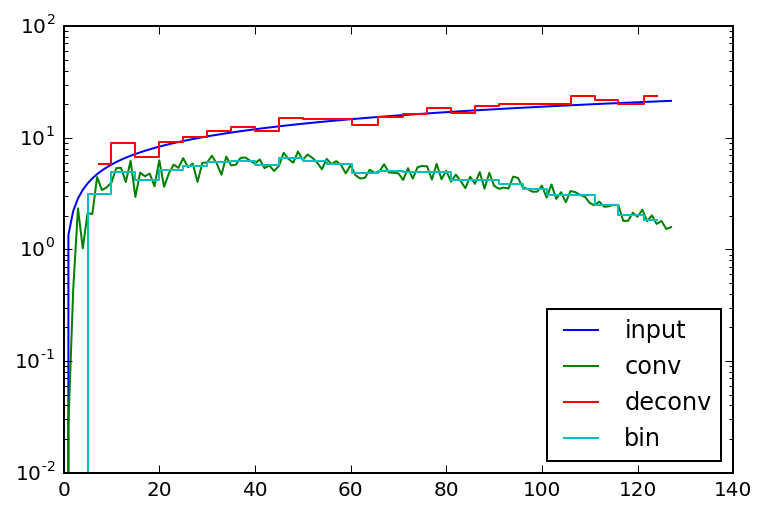

In [103]:
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_in, label='input')
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_conv, label='conv')
pl.plot(bin_centres[1:], cl_deconv, label='deconv', drawstyle='steps-mid')
pl.plot(bin_centres, cl_bin, label='bin', drawstyle='steps-mid')
pl.legend(loc='best')
pl.yscale('log')